# Прогноз риска сердечного инсульта

Цель проекта — построить модель бинарной классификации для предсказания риска сердечного инсульта.
Основное внимание уделяется метрикам Recall, F1-score и ROC-AUC из-за сильного дисбаланса классов.

## 1. Загрузка данных и первичный анализ

На данном этапе выполняется загрузка датасета и анализ структуры данных:
- типы признаков
- наличие пропусков
- базовые статистики

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_curve,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [31]:
df = pd.read_csv('heart_disease.csv')
df

,Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_stroke
0,Male,39,postgraduate,0,0.0,0.0,no,0,0,195.0,106.0,70.0,26.97,80.0,77.0,No
1,Female,46,primaryschool,0,0.0,0.0,no,0,0,250.0,121.0,81.0,28.73,95.0,76.0,No
2,Male,48,uneducated,1,20.0,0.0,no,0,0,245.0,127.5,80.0,25.34,75.0,70.0,No
3,Female,61,graduate,1,30.0,0.0,no,1,0,225.0,150.0,95.0,28.58,65.0,103.0,yes
4,Female,46,graduate,1,23.0,0.0,no,0,0,285.0,130.0,84.0,23.10,85.0,85.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,Male,50,uneducated,1,1.0,0.0,no,1,0,313.0,179.0,92.0,25.97,66.0,86.0,yes
4234,Male,51,graduate,1,43.0,0.0,no,0,0,207.0,126.5,80.0,19.71,65.0,68.0,No
4235,Female,48,primaryschool,1,20.0,NaN,no,0,0,248.0,131.0,72.0,22.00,84.0,86.0,No
4236,Female,44,uneducated,1,15.0,0.0,no,0,0,210.0,126.5,87.0,19.16,86.0,NaN,No


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           4238 non-null   object 
 1   age              4238 non-null   int64  
 2   education        4133 non-null   object 
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   object 
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  Heart_stroke     4238 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 529.9+ KB


In [33]:
df.describe()

,age,currentSmoker,cigsPerDay,BPMeds,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,4238.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000
mean,49.584946,0.494101,9.003089,0.029630,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753
std,8.572160,0.500024,11.920094,0.169584,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998
min,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000
25%,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000
50%,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000
75%,56.000000,1.000000,20.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000
max,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           4238 non-null   object 
 1   age              4238 non-null   int64  
 2   education        4133 non-null   object 
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   object 
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  Heart_stroke     4238 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 529.9+ KB


In [35]:
df.isna().sum()

Gender               0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
Heart_stroke         0
dtype: int64

## 2. Очистка данных и кодирование признаков

В рамках подготовки данных:
- удалены строки с пропущенными значениями
- категориальные признаки закодированы
- целевая переменная приведена к бинарному формату

In [36]:
df = df.dropna().copy()

In [37]:
df['Heart_stroke'].value_counts()

Heart_stroke
No     3099
yes     557
Name: count, dtype: int64

In [38]:
df

,Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_stroke
0,Male,39,postgraduate,0,0.0,0.0,no,0,0,195.0,106.0,70.0,26.97,80.0,77.0,No
1,Female,46,primaryschool,0,0.0,0.0,no,0,0,250.0,121.0,81.0,28.73,95.0,76.0,No
2,Male,48,uneducated,1,20.0,0.0,no,0,0,245.0,127.5,80.0,25.34,75.0,70.0,No
3,Female,61,graduate,1,30.0,0.0,no,1,0,225.0,150.0,95.0,28.58,65.0,103.0,yes
4,Female,46,graduate,1,23.0,0.0,no,0,0,285.0,130.0,84.0,23.10,85.0,85.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,Male,58,graduate,0,0.0,0.0,no,1,0,187.0,141.0,81.0,24.96,80.0,81.0,No
4232,Male,68,uneducated,0,0.0,0.0,no,1,0,176.0,168.0,97.0,23.14,60.0,79.0,yes
4233,Male,50,uneducated,1,1.0,0.0,no,1,0,313.0,179.0,92.0,25.97,66.0,86.0,yes
4234,Male,51,graduate,1,43.0,0.0,no,0,0,207.0,126.5,80.0,19.71,65.0,68.0,No


In [39]:
df['Heart_stroke'] = df['Heart_stroke'].map({'yes': 1, 'No': 0})
df['prevalentStroke'] = df['prevalentStroke'].map({'yes': 1, 'no': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['education'] = pd.Categorical(
    df['education'],
    categories=['uneducated', 'primaryschool', 'graduate', 'postgraduate']
)
df = pd.get_dummies(df, columns=['education'], drop_first=True, dtype=int)
# если все три параметра 0 то это uneducated
df

,Gender,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_stroke,education_primaryschool,education_graduate,education_postgraduate
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,0,0,1
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,1,0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,0,0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1,0,1,0
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,1,58,0,0.0,0.0,0,1,0,187.0,141.0,81.0,24.96,80.0,81.0,0,0,1,0
4232,1,68,0,0.0,0.0,0,1,0,176.0,168.0,97.0,23.14,60.0,79.0,1,0,0,0
4233,1,50,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1,0,0,0
4234,1,51,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0,0,1,0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3656 entries, 0 to 4237
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   3656 non-null   int64  
 1   age                      3656 non-null   int64  
 2   currentSmoker            3656 non-null   int64  
 3   cigsPerDay               3656 non-null   float64
 4   BPMeds                   3656 non-null   float64
 5   prevalentStroke          3656 non-null   int64  
 6   prevalentHyp             3656 non-null   int64  
 7   diabetes                 3656 non-null   int64  
 8   totChol                  3656 non-null   float64
 9   sysBP                    3656 non-null   float64
 10  diaBP                    3656 non-null   float64
 11  BMI                      3656 non-null   float64
 12  heartRate                3656 non-null   float64
 13  glucose                  3656 non-null   float64
 14  Heart_stroke             3656

In [42]:
df

,Gender,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_stroke,education_primaryschool,education_graduate,education_postgraduate
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,0,0,1
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,1,0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,0,0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1,0,1,0
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,1,58,0,0.0,0.0,0,1,0,187.0,141.0,81.0,24.96,80.0,81.0,0,0,1,0
4232,1,68,0,0.0,0.0,0,1,0,176.0,168.0,97.0,23.14,60.0,79.0,1,0,0,0
4233,1,50,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1,0,0,0
4234,1,51,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0,0,1,0


## 3. Исследовательский анализ данных (EDA)

Цель этапа — изучить:
- дисбаланс классов
- взаимосвязь признаков с целевой переменной
- наличие мультиколлинеарности

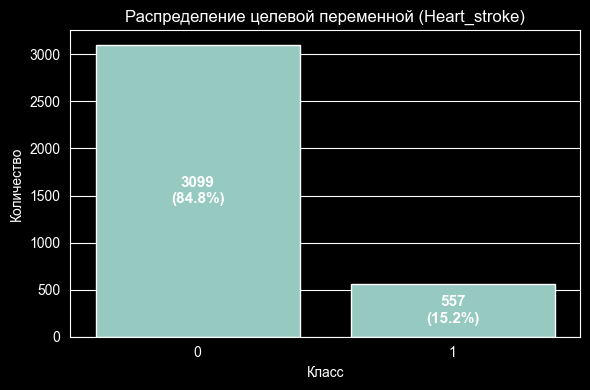

In [43]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x='Heart_stroke',
    data=df
)

total = len(df)

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        f'{count}\n({count / total:.1%})',
        (p.get_x() + p.get_width() / 2., p.get_height() / 2),
        ha='center',
        va='center',
        color='white',  # чтобы читалось внутри
        fontsize=11,
        fontweight='bold'
    )

plt.title('Распределение целевой переменной (Heart_stroke)')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

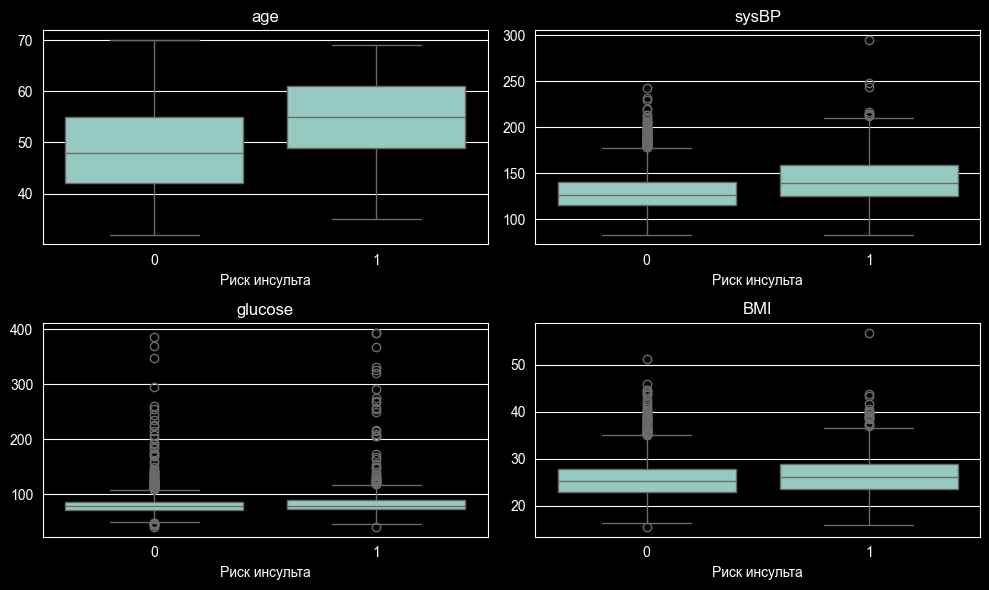

In [44]:
features = ['age', 'sysBP', 'glucose', 'BMI']

plt.figure(figsize=(10, 6))

for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(
        x='Heart_stroke',
        y=col,
        data=df
    )
    plt.title(col)
    plt.xlabel('Риск инсульта')
    plt.ylabel('')

plt.tight_layout()
plt.show()

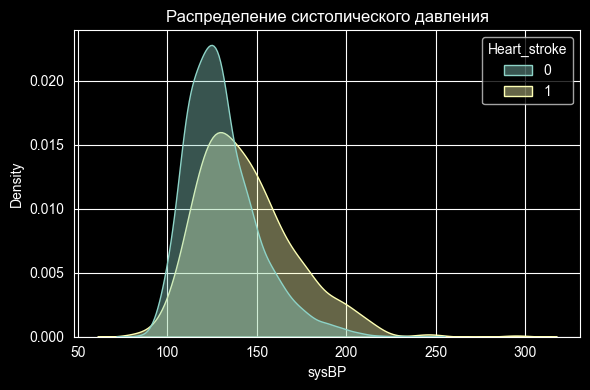

In [45]:
plt.figure(figsize=(6, 4))
sns.kdeplot(
    data=df,
    x='sysBP',
    hue='Heart_stroke',
    fill=True,
    common_norm=False,
    alpha=0.4
)
plt.title('Распределение систолического давления')
plt.tight_layout()
plt.show()

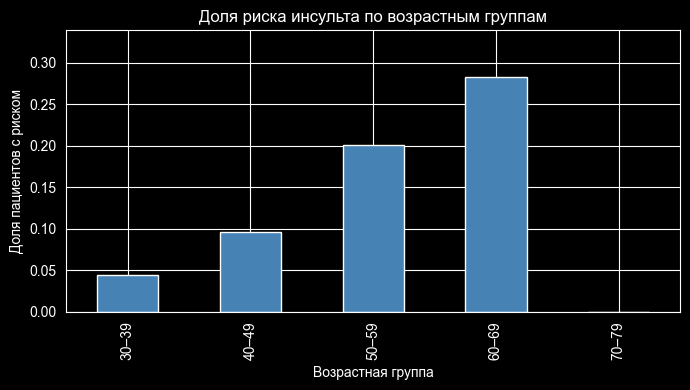

In [46]:
df_plot = df.copy()

bins = [30, 40, 50, 60, 70, 80, 120]
labels = ['30–39', '40–49', '50–59', '60–69', '70–79', '80+']

df_plot['age_group'] = pd.cut(
    df_plot['age'],
    bins=bins,
    labels=labels,
    right=False
)

risk_by_age = (
    df_plot
    .groupby('age_group', observed=True)['Heart_stroke']
    .mean()
)

plt.figure(figsize=(7, 4))
risk_by_age.plot(kind='bar', color='steelblue')
plt.title('Доля риска инсульта по возрастным группам')
plt.ylabel('Доля пациентов с риском')
plt.xlabel('Возрастная группа')
plt.ylim(0, risk_by_age.max() * 1.2)
plt.tight_layout()
plt.show()

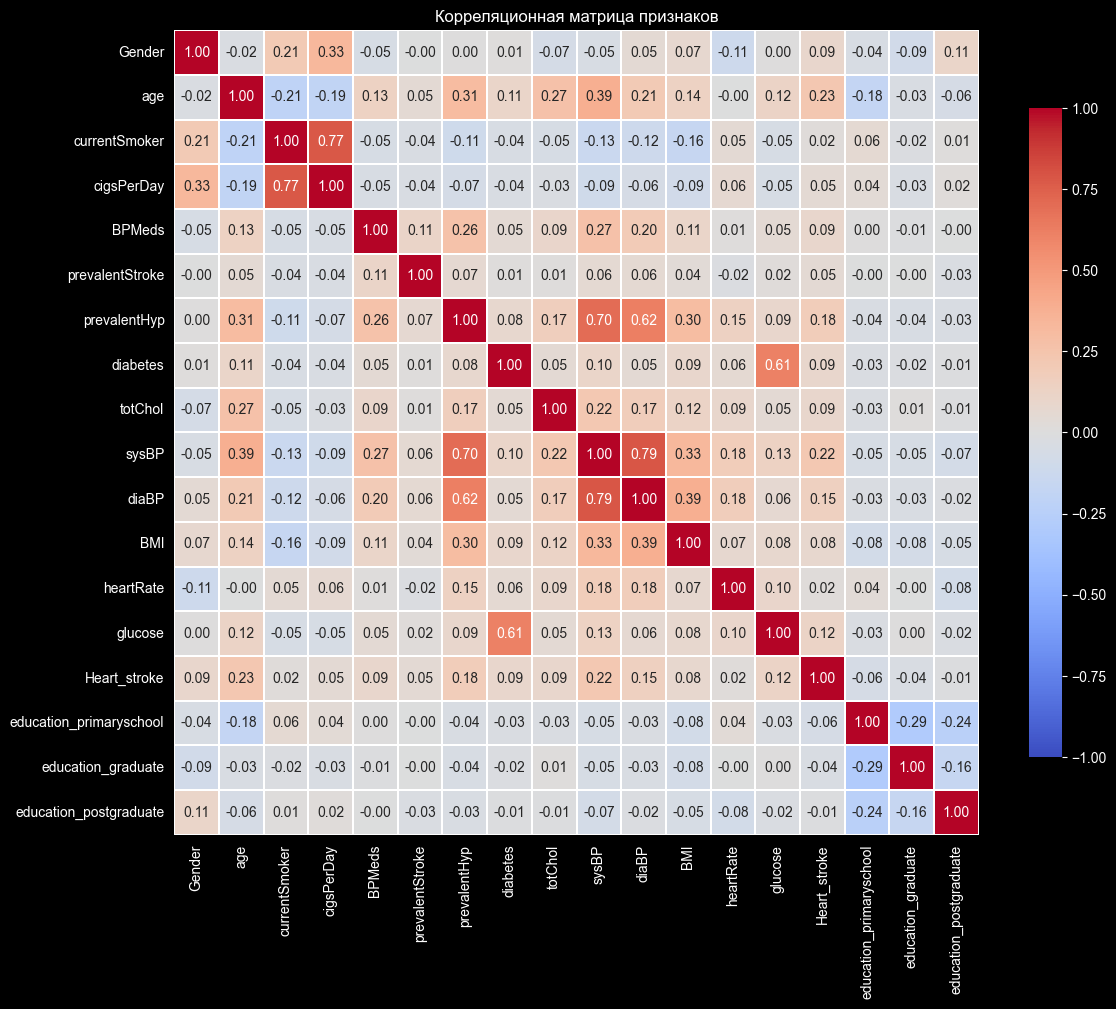

In [47]:
plt.figure(figsize=(12, 10))

corr_matrix = df.corr(numeric_only=True)

sns.heatmap(
    corr_matrix,
    annot=True,  # ← ВКЛЮЧАЕМ ЦИФРЫ
    fmt=".2f",  # 2 знака после запятой
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.3,
    cbar_kws={'shrink': 0.8}
)

plt.title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()

## 4. Подготовка данных к моделированию

Данные разделены на обучающую и тестовую выборки (80/20) с сохранением пропорций классов.
Для корректной работы линейных моделей выполнено масштабирование числовых признаков.

In [48]:
X = df.drop('Heart_stroke', axis=1)
y = df['Heart_stroke']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (2924, 17)
Размер тестовой выборки: (732, 17)


## 5. Базовая модель: Logistic Regression

Логистическая регрессия выбрана как интерпретируемая базовая модель,
подходящая для медицинских задач с бинарным исходом.

In [49]:
logreg = LogisticRegression(
    class_weight='balanced',
    max_iter=2000,
    solver='liblinear',
    random_state=42
)

logreg.fit(X_train_scaled, y_train)

y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

## 6. Подбор порога классификации

Так как стандартный порог 0.5 не оптимален при дисбалансе классов,
был выполнен подбор порога по F1-score.

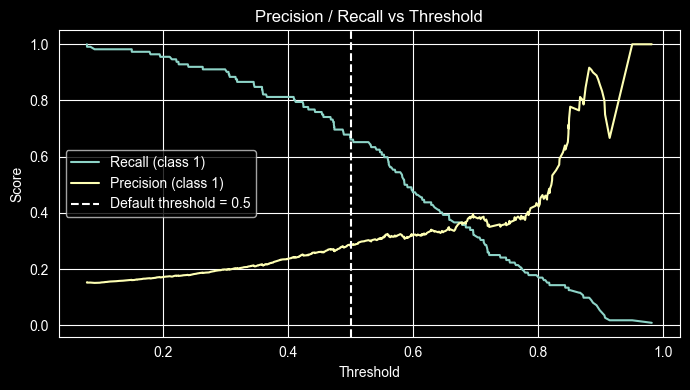

Best threshold: 0.50
Best F1-score (class 1): 0.402


In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(7, 4))

plt.plot(thresholds, recall[:-1], label='Recall (class 1)')
plt.plot(thresholds, precision[:-1], label='Precision (class 1)')

plt.axvline(0.5, linestyle='--', label='Default threshold = 0.5')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# Автоподбор порога по F1
# =========================
thresholds = np.linspace(0.05, 0.5, 100)
best_threshold = 0
best_f1 = 0
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1 = f1_score(
        y_test,
        y_pred_t,
        zero_division=0
    )
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold: {best_threshold:.2f}")
print(f"Best F1-score (class 1): {best_f1:.3f}")


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.92      0.69      0.79       620
           1       0.29      0.68      0.40       112

    accuracy                           0.69       732
   macro avg       0.60      0.69      0.60       732
weighted avg       0.83      0.69      0.73       732

ROC-AUC Score: 0.7328


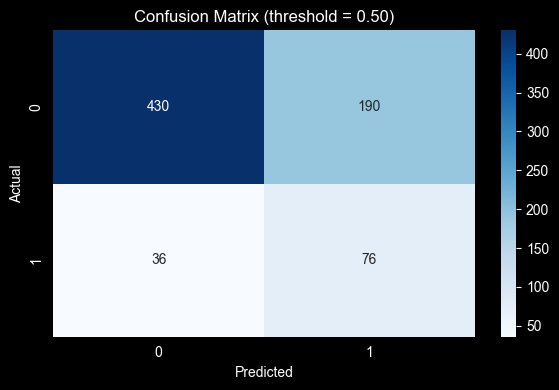

In [51]:
# =========================
# Финальные предсказания
# =========================

# threshold = 0.4
threshold = best_threshold
y_pred_custom = (y_proba >= threshold).astype(int)

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_custom))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# =========================
# Confusion Matrix
# =========================
cm = confusion_matrix(y_test, y_pred_custom)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues'
)
plt.title(f'Confusion Matrix (threshold = {threshold:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 7. Балансировка классов с использованием SMOTE

Для борьбы с дисбалансом классов применён метод SMOTE,
который выполняет oversampling миноритарного класса.

In [52]:
smote = SMOTE(
    sampling_strategy=1.0,
    random_state=42
)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train_scaled, y_train
)
print("До SMOTE:", y_train.value_counts())
print("После SMOTE:", pd.Series(y_train_smote).value_counts())

logreg_smote = LogisticRegression(
    max_iter=2000,
    solver='liblinear',
    random_state=42
)

logreg_smote.fit(X_train_smote, y_train_smote)

y_proba_smote = logreg_smote.predict_proba(X_test_scaled)[:, 1]

До SMOTE: Heart_stroke
0    2479
1     445
Name: count, dtype: int64
После SMOTE: Heart_stroke
0    2479
1    2479
Name: count, dtype: int64


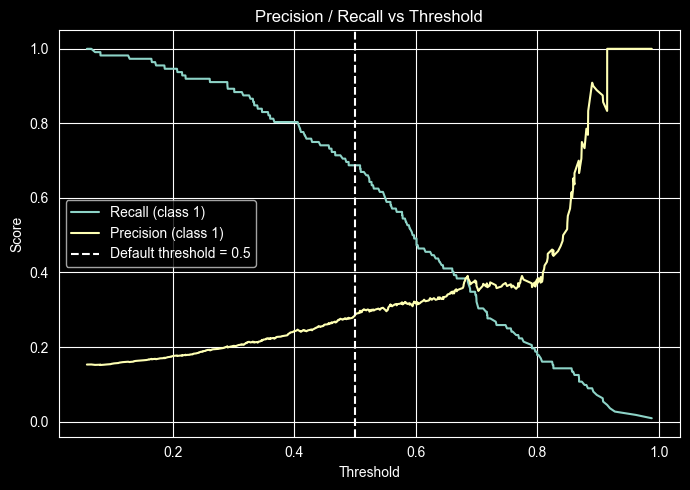

Best threshold: 0.50
Best F1-score (class 1): 0.405


In [53]:
# precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_smote)

plt.figure(figsize=(7, 5))

plt.plot(thresholds, recall[:-1], label='Recall (class 1)')
plt.plot(thresholds, precision[:-1], label='Precision (class 1)')

plt.axvline(0.5, linestyle='--', label='Default threshold = 0.5')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# 4. Автоподбор порога по F1
# =========================
thresholds = np.linspace(0.05, 0.5, 100)

best_threshold = 0
best_f1 = 0

for t in thresholds:
    y_pred_t = (y_proba_smote >= t).astype(int)

    f1 = f1_score(
        y_test,
        y_pred_t,
        zero_division=0
    )

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold: {best_threshold:.2f}")
print(f"Best F1-score (class 1): {best_f1:.3f}")

Classification Report (LogReg + SMOTE):
              precision    recall  f1-score   support

           0       0.92      0.69      0.79       620
           1       0.29      0.69      0.41       112

    accuracy                           0.69       732
   macro avg       0.61      0.69      0.60       732
weighted avg       0.83      0.69      0.73       732

ROC-AUC: 0.7323012672811058


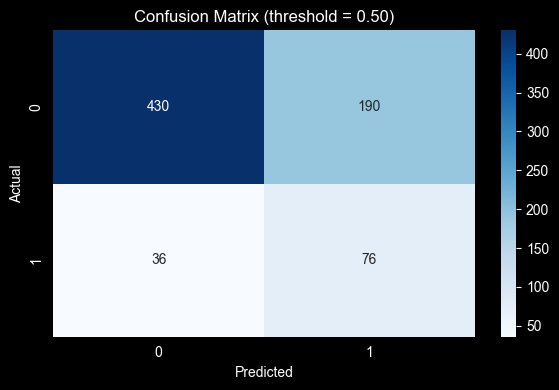

In [54]:
# threshold = 0.4
threshold = best_threshold
y_pred_smote = (y_proba_smote >= threshold).astype(int)

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print("Classification Report (LogReg + SMOTE):")
print(classification_report(y_test, y_pred_smote))

print("ROC-AUC:", roc_auc_score(y_test, y_proba_smote))

# =========================
# Confusion Matrix
# =========================
cm = confusion_matrix(y_test, y_pred_custom)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues'
)
plt.title(f'Confusion Matrix (threshold = {threshold:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 8. Ансамблевые модели: Random Forest

Random Forest протестирован как более сложная нелинейная модель,
устойчивая к выбросам и способная учитывать взаимодействия признаков.

In [55]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight='balanced'

)

rf_model.fit(X_train_scaled, y_train)

# 2. Вероятности (ВАЖНО)
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

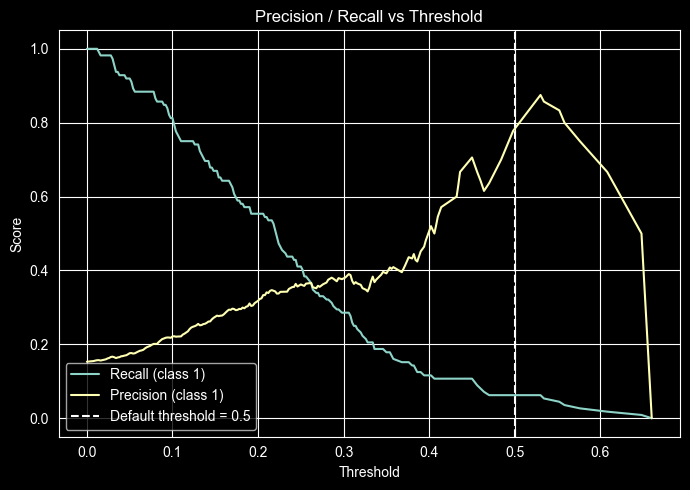

Best threshold: 0.21
Best F1-score: 0.419


In [56]:
# precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(7, 5))

plt.plot(thresholds, recall[:-1], label='Recall (class 1)')
plt.plot(thresholds, precision[:-1], label='Precision (class 1)')

plt.axvline(0.5, linestyle='--', label='Default threshold = 0.5')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# 4. Автоподбор порога по F1
# =========================
thresholds = np.linspace(0.0, 1.0, 101)

best_threshold = 0
best_f1 = 0

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold: {best_threshold:.2f}")
print(f"Best F1-score: {best_f1:.3f}")

Classification Report (Random Forest | threshold = 0.16):
              precision    recall  f1-score   support

           0       0.92      0.70      0.80       620
           1       0.28      0.64      0.39       112

    accuracy                           0.69       732
   macro avg       0.60      0.67      0.59       732
weighted avg       0.82      0.69      0.73       732

ROC-AUC Score: 0.7206


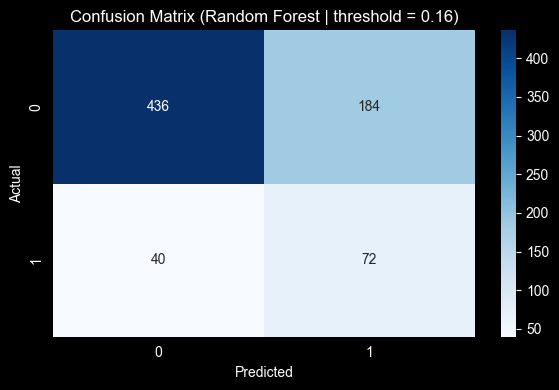

In [57]:
# 3. Кастомный порог

# threshold = best_threshold
threshold = 0.16

y_pred_custom = (y_proba >= threshold).astype(int)

# 4. Метрики
print(f"Classification Report (Random Forest | threshold = {threshold}):")
print(classification_report(y_test, y_pred_custom))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# 5. Матрица ошибок
cm = confusion_matrix(y_test, y_pred_custom)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues'
)
plt.title(f'Confusion Matrix (Random Forest | threshold = {threshold})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

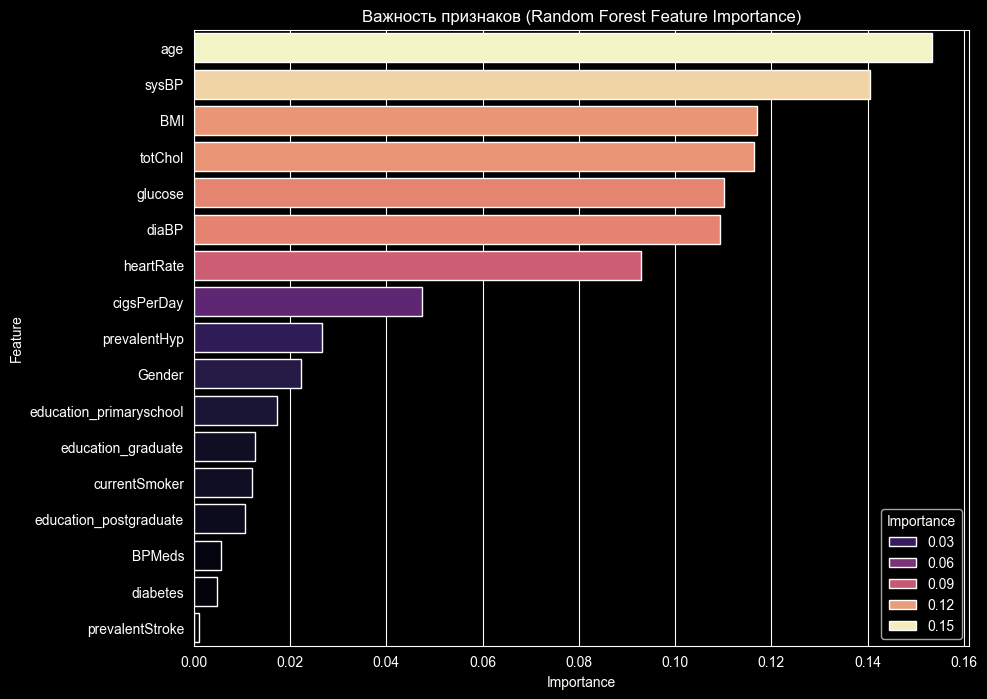

Топ-5 наиболее значимых признаков:


,Feature,Importance
1,age,0.153371
9,sysBP,0.140484
11,BMI,0.116930
8,totChol,0.116363
13,glucose,0.110095
10,diaBP,0.109426
12,heartRate,0.092910
3,cigsPerDay,0.047372
6,prevalentHyp,0.026630
0,Gender,0.022238


In [58]:
# Извлечение и визуализация важности признаков
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma', hue='Importance')
plt.title('Важность признаков (Random Forest Feature Importance)')
plt.show()

print("Топ-5 наиболее значимых признаков:")
feature_importance_df
